<a href="https://colab.research.google.com/github/ModoSerio/Inteligencia_Artificial_Udea/blob/main/02-ModelosMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download vbookshelf/respiratory-sound-database

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import math
from matplotlib.cbook import boxplot_stats
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h3>Importando el diagnóstico </h3>

al mirar en el dataset el archivo llamado patient_diagnosis vemos que este tiene 2 columnas, en la cuál la primera es el ID del paciente y la segunda es la enfermedad que este tiene.


las abreviaciones usadas en la columna de diagnóstico son:
- COPD: Chronic Obstructive Pulmonary Disease
- LRTI: Lower Respiratory Tract Infection
- URTI: Upper Respiratory Tract Infection

In [ ]:
patient_data=pd.read_csv('/content/drive/MyDrive/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['pid','Enfermedad'])
patient_data.head()

,pid,Enfermedad
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


Ahora miremos como están organizados los datos en los archivos txt de los audios


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.txt',sep='\t')
df.head()

,0.364,3.25,0,1
0,3.250,6.636,0,0
1,6.636,11.179,0,1
2,11.179,14.250,0,1
3,14.250,16.993,0,1
4,16.993,19.979,0,0


según nos dice la descripción del dataset, las columnas significan lo siguiente:

Las cuatro columnas son:
- Comienzo de los ciclos respiratorios
- Fin del ciclo respiratorio
- Presencia/ausencia de crepitancias (presencia=1, ausencia=0)
- Presencia/ausencia de sibilancias (presencia=1, ausencia=0)

In [ ]:
path='/content/drive/MyDrive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:100]

['160_1b3_Al_mc_AKGC417L',
 '160_1b3_Ar_mc_AKGC417L',
 '160_1b3_Pr_mc_AKGC417L',
 '160_1b4_Al_mc_AKGC417L',
 '160_1b3_Pl_mc_AKGC417L',
 '160_1b3_Lr_mc_AKGC417L',
 '160_2b4_Pl_mc_AKGC417L',
 '160_1b4_Pr_mc_AKGC417L',
 '160_1b4_Lr_mc_AKGC417L',
 '160_2b4_Ar_mc_AKGC417L',
 '160_2b3_Lr_mc_AKGC417L',
 '160_1b4_Pl_mc_AKGC417L',
 '160_1b4_Tc_mc_AKGC417L',
 '160_2b4_Pr_mc_AKGC417L',
 '162_1b2_Ar_mc_AKGC417L',
 '162_1b2_Ll_mc_AKGC417L',
 '162_1b2_Pl_mc_AKGC417L',
 '162_1b2_Lr_mc_AKGC417L',
 '161_1b1_Pl_sc_Meditron',
 '161_1b1_Al_sc_Meditron',
 '162_1b2_Al_mc_AKGC417L',
 '160_2b4_Tc_mc_AKGC417L',
 '162_2b2_Pr_mc_AKGC417L',
 '162_2b2_Al_mc_AKGC417L',
 '162_2b2_Pl_mc_AKGC417L',
 '162_2b2_Ar_mc_AKGC417L',
 '162_2b2_Tc_mc_AKGC417L',
 '162_1b2_Pr_mc_AKGC417L',
 '162_1b2_Tc_mc_AKGC417L',
 '162_2b3_Ar_mc_AKGC417L',
 '162_2b3_Pr_mc_AKGC417L',
 '162_2b3_Tc_mc_AKGC417L',
 '162_2b3_Pl_mc_AKGC417L',
 '162_2b3_Lr_mc_AKGC417L',
 '162_2b3_Al_mc_AKGC417L',
 '162_2b4_Al_mc_AKGC417L',
 '162_2b4_Ar_mc_AKGC417L',
 

Cada audio está dividido en 5 elementos separados por un '_'. Estos 5 elementos son:

1. Número de paciente (101,102,...,226)
2. index de grabación
3. Ubicación
      a. Trachea (Tc)
      b. Anterior left (Al)
      c. Anterior right (Ar)
      d. Posterior left (Pl)
      e. Posterior right (Pr)
      f. Lateral left (Ll)
      g. Lateral right (Lr)
4. Modo de adquisición
     a. sequential/single channel (sc), 
     b. simultaneous/multichannel (mc)
5. Equipo de grabación
     a. AKG C417L Microphone (AKGC417L), 
     b. 3M Littmann Classic II SE Stethoscope (LittC2SE), 
     c. 3M Litmmann 3200 Electronic Stethoscope (Litt3200), 
     d.  WelchAllyn Meditron Master Elite Electronic  Stethoscope (Meditron)


Podemos convertir este formato a una lista para poder trabajar mejor de esta manera:

In [ ]:
def getFilenameInfo(file):
    return file.split('_')
getFilenameInfo('172_1b3_Ar_mc_AKGC417L')

['172', '1b3', 'Ar', 'mc', 'AKGC417L']

Ahora usando estos datos crearemos un dataset que resuma la información que está en patient diagnosis y en los archivos .txt

In [ ]:

files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['inicio','fin','crepitancias','sibilancias'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['modo']=name_data[-2]
    data['nombre']=file
    files_data.append(data)
files_df = pd.concat(files_data)
pid_unique = np.unique(files_df['pid'])
files_df.reset_index()


sib = []
crep = []
total_df = pd.DataFrame()
total_df['pid'] = pid_unique

for i in pid_unique:
  a = files_df.loc[files_df['pid'] == i]
  sum_crep = a['crepitancias'].mean()
  sum_sib = a['sibilancias'].mean()
  sib.append(sum_sib)
  crep.append(sum_crep)

total_df['Crepitancias_mean'] = crep
total_df['Sibilancias_mean'] = sib
#ahora tenemos los promedios de crepitancias y sibilancias para todos los sujetos 

files_df.head(15)



,inicio,fin,crepitancias,sibilancias,pid,modo,nombre
0,1.862,5.718,0,1,160,mc,160_1b3_Al_mc_AKGC417L
1,5.718,9.725,1,1,160,mc,160_1b3_Al_mc_AKGC417L
2,9.725,13.614,0,1,160,mc,160_1b3_Al_mc_AKGC417L
3,13.614,17.671,0,1,160,mc,160_1b3_Al_mc_AKGC417L
4,17.671,19.541,0,0,160,mc,160_1b3_Al_mc_AKGC417L
0,1.862,5.718,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
1,5.718,9.725,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
2,9.725,13.614,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
3,13.614,17.671,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
4,17.671,19.541,0,0,160,mc,160_1b3_Ar_mc_AKGC417L


Dataframe con el promedio de sibilancias y crepitancias en todos los audios para cada sujeto

In [ ]:
total_df

,pid,Crepitancias_mean,Sibilancias_mean
0,101,0.000000,0.000000
1,102,0.000000,0.000000
2,103,0.000000,0.666667
3,104,0.018182,0.181818
4,105,0.000000,0.000000
...,...,...,...
121,222,0.288889,0.177778
122,223,0.311475,0.213115
123,224,0.000000,0.000000
124,225,0.000000,0.000000


Por último mezclamos los dataframes del diagnóstico y el que acabamos de crear


In [ ]:
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')
data=pd.merge(files_df,patient_data,on='pid')
data.head()


,inicio,fin,crepitancias,sibilancias,pid,modo,nombre,Enfermedad
0,1.862,5.718,0,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
1,5.718,9.725,1,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
2,9.725,13.614,0,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
3,13.614,17.671,0,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
4,17.671,19.541,0,0,160,mc,160_1b3_Al_mc_AKGC417L,COPD


<h3> Preprocesamiento de los audios

para preprocesar los audios, se creó un dataframe que contuviera los datos presentes en el archivo audio_and_txt_files. Además, se añadió una columna que tuviera la longitud del ciclo respiratorio, esto se hizo restando el tiempo final del ciclo con el tiempo de inicio

In [ ]:
root = path
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['inicio','fin','crepitancias','sibilancias'], delimiter= '\t')
    return (recording_annotations)

In [ ]:
rec_annotations_dict = {}
for s in files:
    a = Extract_Annotation_Data(s, root)
    rec_annotations_dict[s] = a
my_index = pd.Series(list(rec_annotations_dict.keys()))

In [ ]:
res_rate_list = []
for i in range (920):
    ciclo = pd.DataFrame( list(rec_annotations_dict.values())[i],columns=['inicio', 'fin' ,'Longitud de ciclo'])
    ciclo['Longitud de ciclo'] = ciclo['fin']-ciclo['inicio']
    prom = ciclo[["inicio","fin","Longitud de ciclo"]].mean(axis=0)
    ciclos_df= pd.DataFrame(prom).T
    res_rate_list.append(ciclos_df)

In [ ]:
res_rate_df = pd.concat(res_rate_list,ignore_index =True)
res_rate_df['filename']= my_index.values
res_rate_df['filename']= res_rate_df['filename'].str[:3]
res_rate_df.sort_values(by=['filename'])
res_rate_df.head(919)

,inicio,fin,Longitud de ciclo,filename
0,9.718000,13.253800,3.535800,160
1,9.718000,13.253800,3.535800,160
2,9.718000,13.253800,3.535800,160
3,8.769000,13.238750,4.469750,160
4,9.718000,13.253800,3.535800,160
...,...,...,...,...
914,9.551583,11.212250,1.660667,159
915,2.437500,7.554000,5.116500,160
916,9.413333,11.626111,2.212778,159
917,2.437500,7.554000,5.116500,160


In [ ]:
from pandas.core.missing import F
#Se halla la frecuencia respiratoria
res_rate_df= res_rate_df.groupby('filename').mean()
res_rate_df['FR'] = np.round(60/res_rate_df['Longitud de ciclo'],0)

#Frecuencia respiratoria normal 12-25 ciclos/min
res_rate_df['Diagnostico FR'] = 0
res_rate_df['pid'] = res_rate_df.index
res_rate_df['Diagnostico FR'][(res_rate_df['FR'] > 25)] = 1 
res_rate_df

<ipython-input-337-7651ba22f3a1>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,inicio,fin,Longitud de ciclo,FR,Diagnostico FR,pid
filename,,,,,,
101,9.002485,10.737364,1.734879,35.0,1,101
102,9.807231,11.322615,1.515385,40.0,1,102
103,8.778667,12.047833,3.269167,18.0,0,103
104,8.795221,11.078845,2.283624,26.0,1,104
105,9.198375,11.682250,2.483875,24.0,0,105
...,...,...,...,...,...,...
222,35.535680,40.488657,4.952977,12.0,0,222
223,15.320182,18.412637,3.092455,19.0,0,223
224,9.680714,12.529643,2.848929,21.0,0,224


Text(0.5, 0, 'Diagnostico FR')

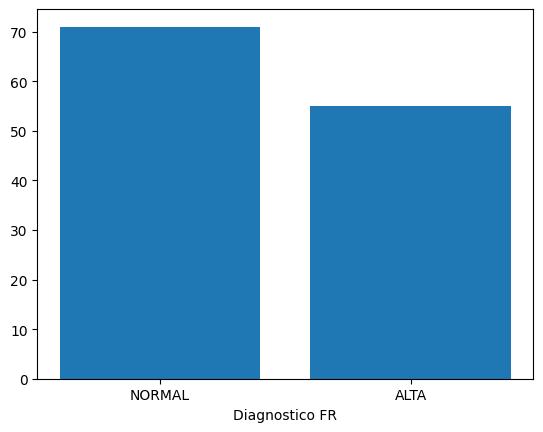

In [ ]:
FR_ALTA = []
FR_NORMAL =[]
for i in res_rate_df['Diagnostico FR']:
  if i == 0:
    FR_NORMAL.append(i)
  else:
    FR_ALTA.append(i)

n=len(FR_NORMAL)
a=len(FR_ALTA)
FRD = ["NORMAL", "ALTA"]
diag = [n,a]

fig, ax = plt.subplots()
ax.bar(x = FRD, height = diag )
plt.xlabel("Diagnostico FR")

<h3> Preprocesamiento de la información demográfica


In [ ]:
df_no_diagnosis = pd.read_csv('/content/drive/MyDrive/Respiratory_Sound_Database/demographic_info.txt', names = 
                 ['pid', 'Edad', 'Genero' , 'BMI (kg/m2)', 'Peso (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')
df_no_diagnosis.head(10)

,pid,Edad,Genero,BMI (kg/m2),Peso (kg),Child Height (cm)
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0
5,106,73.00,F,21.00,NaN,NaN
6,107,75.00,F,33.70,NaN,NaN
7,108,3.00,M,NaN,NaN,NaN
8,109,84.00,F,33.53,NaN,NaN
9,110,75.00,M,25.21,NaN,NaN


Mezclamos los dataframes de la informacion demografica  y el dataframe de diagnostico de pacientes

In [ ]:
df =  df_no_diagnosis.join(patient_data.set_index('pid'), on = 'pid', how = 'left')
df.head(10)


,pid,Edad,Genero,BMI (kg/m2),Peso (kg),Child Height (cm),Enfermedad
0,101,3.00,F,NaN,19.0,99.0,URTI
1,102,0.75,F,NaN,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.0,135.0,URTI
5,106,73.00,F,21.00,NaN,NaN,COPD
6,107,75.00,F,33.70,NaN,NaN,COPD
7,108,3.00,M,NaN,NaN,NaN,LRTI
8,109,84.00,F,33.53,NaN,NaN,COPD
9,110,75.00,M,25.21,NaN,NaN,COPD


Se remplazan los valores en NaN presentes en el dataframe y se eliminan las filas que consideramos no tendrían una información relevante 

In [ ]:
df.fillna(0, inplace=True)
df.head(10)

,pid,Edad,Genero,BMI (kg/m2),Peso (kg),Child Height (cm),Enfermedad
0,101,3.00,F,0.00,19.0,99.0,URTI
1,102,0.75,F,0.00,9.8,73.0,Healthy
2,103,70.00,F,33.00,0.0,0.0,Asthma
3,104,70.00,F,28.47,0.0,0.0,COPD
4,105,7.00,F,0.00,32.0,135.0,URTI
5,106,73.00,F,21.00,0.0,0.0,COPD
6,107,75.00,F,33.70,0.0,0.0,COPD
7,108,3.00,M,0.00,0.0,0.0,LRTI
8,109,84.00,F,33.53,0.0,0.0,COPD
9,110,75.00,M,25.21,0.0,0.0,COPD


In [ ]:
df['Diagnostico']=0
x,y = df.shape
for c in range(x):
  valor_actual = df['Enfermedad'].iloc[c]
  if "Healthy" in valor_actual:
    df.at[c,"Diagnostico"] = 0
  else: 
    df.at[c,"Diagnostico"] = 1  
df

,pid,Edad,Genero,BMI (kg/m2),Peso (kg),Child Height (cm),Enfermedad,Diagnostico
0,101,3.00,F,0.00,19.0,99.0,URTI,1
1,102,0.75,F,0.00,9.8,73.0,Healthy,0
2,103,70.00,F,33.00,0.0,0.0,Asthma,1
3,104,70.00,F,28.47,0.0,0.0,COPD,1
4,105,7.00,F,0.00,32.0,135.0,URTI,1
...,...,...,...,...,...,...,...,...
121,222,60.00,M,0.00,0.0,0.0,COPD,1
122,223,0.00,0,0.00,0.0,0.0,COPD,1
123,224,10.00,F,0.00,32.3,143.0,Healthy,0
124,225,0.83,M,0.00,7.8,74.0,Healthy,0


In [ ]:
#Finalmente se eliminaran las columnas que se consideran innecesarias pues no aportan la suficiente informacion al problema
columnas_eliminar = ['BMI (kg/m2)','Child Height (cm)','Peso (kg)']
df.drop(columnas_eliminar, axis=1, inplace=True)
df

,pid,Edad,Genero,Enfermedad,Diagnostico
0,101,3.00,F,URTI,1
1,102,0.75,F,Healthy,0
2,103,70.00,F,Asthma,1
3,104,70.00,F,COPD,1
4,105,7.00,F,URTI,1
...,...,...,...,...,...
121,222,60.00,M,COPD,1
122,223,0.00,0,COPD,1
123,224,10.00,F,Healthy,0
124,225,0.83,M,Healthy,0


In [ ]:
#Con el fin de obtener una matriz con valores numericos se pondra la columna de genero con M = 1 y F = 0
df.Genero[df.Genero=="M"]=1;df.Genero[df.Genero=="F"]=1;#df.Edad=df.Edad.astype(int); 
df

<ipython-input-344-f0b96f49b4d3>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,pid,Edad,Genero,Enfermedad,Diagnostico
0,101,3.00,1,URTI,1
1,102,0.75,1,Healthy,0
2,103,70.00,1,Asthma,1
3,104,70.00,1,COPD,1
4,105,7.00,1,URTI,1
...,...,...,...,...,...
121,222,60.00,1,COPD,1
122,223,0.00,0,COPD,1
123,224,10.00,1,Healthy,0
124,225,0.83,1,Healthy,0


En este otro df tenemos 2 columnas extras que corresponden al promedio de sibilancias y crepitancias que se escucharon en los audios

In [ ]:
total_df.pid=total_df.pid.astype('int32')
df_con_mean=pd.merge(total_df,df,on='pid')
df_con_mean


,pid,Crepitancias_mean,Sibilancias_mean,Edad,Genero,Enfermedad,Diagnostico
0,101,0.000000,0.000000,3.00,1,URTI,1
1,102,0.000000,0.000000,0.75,1,Healthy,0
2,103,0.000000,0.666667,70.00,1,Asthma,1
3,104,0.018182,0.181818,70.00,1,COPD,1
4,105,0.000000,0.000000,7.00,1,URTI,1
...,...,...,...,...,...,...,...
121,222,0.288889,0.177778,60.00,1,COPD,1
122,223,0.311475,0.213115,0.00,0,COPD,1
123,224,0.000000,0.000000,10.00,1,Healthy,0
124,225,0.000000,0.000000,0.83,1,Healthy,0


Ahora creamos otro dataframe con los datos del anterior dataframe pero con datos sobre la frecuencia respiratoria

In [ ]:
#Finalmente se eliminaran las columnas que se consideran innecesarias pues no aportan la suficiente informacion al problema
columnas_eliminar = ['inicio','fin','Longitud de ciclo']
res_rate_df.drop(columnas_eliminar, axis=1, inplace=True)
res_rate_df

,FR,Diagnostico FR,pid
filename,,,
101,35.0,1,101
102,40.0,1,102
103,18.0,0,103
104,26.0,1,104
105,24.0,0,105
...,...,...,...
222,12.0,0,222
223,19.0,0,223
224,21.0,0,224


In [ ]:
res_rate_df=res_rate_df.astype('int32')
df_it_3=pd.merge(df_con_mean,res_rate_df,on='pid')
df_it_3

,pid,Crepitancias_mean,Sibilancias_mean,Edad,Genero,Enfermedad,Diagnostico,FR,Diagnostico FR
0,101,0.000000,0.000000,3.00,1,URTI,1,35,1
1,102,0.000000,0.000000,0.75,1,Healthy,0,40,1
2,103,0.000000,0.666667,70.00,1,Asthma,1,18,0
3,104,0.018182,0.181818,70.00,1,COPD,1,26,1
4,105,0.000000,0.000000,7.00,1,URTI,1,24,0
...,...,...,...,...,...,...,...,...,...
121,222,0.288889,0.177778,60.00,1,COPD,1,12,0
122,223,0.311475,0.213115,0.00,0,COPD,1,19,0
123,224,0.000000,0.000000,10.00,1,Healthy,0,21,0
124,225,0.000000,0.000000,0.83,1,Healthy,0,42,1


**Visualizacion de distribuciones**

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as ply_go

In [ ]:
bin_size_dict = dict( Edad=1, BMI=5.0, Enfermedad=1,Genero=1)
xaxis_title_dict = dict(Edad='Edad', BMI="BMI", Enfermedad="Enfermedad", Genero="Mujer/Hombre")

for c in ['Edad', 'Enfermedad']:
    hist_data = ply_go.Histogram(x=df[c], name=c, showlegend=False, xbins={'size':bin_size_dict[c]})
    fig = ply_go.Figure(data=[hist_data])
    fig.update_layout(title={'text': c+" distribucion"}, xaxis={"title":{"text":xaxis_title_dict[c]}})
    fig.show()

In [ ]:
my_title_layout = dict({"text":"Distribucion", 'xanchor':'center', 'x':0.5, 'y':0.9, 'font':{'size':24}})
my_layout = dict(title=my_title_layout)

In [ ]:
fig = ply_go.Figure( layout=my_layout)
for tmp_diag in df['Enfermedad'].unique():
    violin_data = ply_go.Violin(x=df.loc[df['Enfermedad']==tmp_diag, 'Enfermedad'],
                                y=df.loc[df['Enfermedad']==tmp_diag, 'Edad'],
                                name=tmp_diag,
                                box_visible=True,
                                meanline_visible=True)
    fig.add_trace(violin_data)
fig.show()

**ITERACIÓN 1**

In [ ]:
from sklearn.neural_network import MLPClassifier #Multi-layer Perceptron classifier
from sklearn.model_selection import train_test_split #Split arrays or matrices into random train and test subsets.
from sklearn.metrics import mean_squared_error #Mean squared error regression loss.
from math import sqrt
from sklearn.metrics import r2_score # (coefficient of determination) regression score function.
from sklearn.metrics import classification_report,confusion_matrix #Build a text report showing the main classification metrics.
from sklearn.model_selection import ShuffleSplit

In [ ]:
#Funcion para graficar matrices de confusion 

from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
df.drop("Enfermedad", axis=1, inplace=True)
target_column = ['Diagnostico'] #Sano - Enfermo
predictors = list(set(list(df.columns))-set(target_column))
print(predictors)

df[predictors] = df[predictors]/df[predictors].max()
df.describe()

['pid', 'Edad', 'Genero']


,Diagnostico
count,126.000000
mean,0.793651
std,0.406300
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
X1 = df[predictors].values
y1 = df[target_column].values

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=40) #test 30% - train 70%, flag = 40
y1_test = np.squeeze(y1_test)
y1_train = np.squeeze(y1_train) 
print(X1_train.shape)
print(y1_train.shape)

print(X1_test.shape)
print(y1_test.shape)

(88, 3)
(88,)
(38, 3)
(38,)


In [ ]:
# creación de un objeto de la clase MLPClassifier, que es un clasificador de redes neuronales multicapa (Multi-Layer Perceptron, MLP) en la biblioteca scikit-learn.
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500) 
print(mlp)

MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=500)


In [ ]:
# se entrena el modelo MLPClassifier y realizan predicciones utilizando el conjunto de entrenamiento y el conjunto de prueba.
mlp.fit(X1_train,y1_train) 
predict_train = mlp.predict(X1_train) 
predict_test = mlp.predict(X1_test)

In [ ]:
print(confusion_matrix(y1_test,predict_test))

[[ 3  1]
 [ 6 28]]


In [ ]:
target_names = ['Sanos', 'Enfermos']
print(classification_report(y1_test,predict_test,target_names=target_names))

              precision    recall  f1-score   support

       Sanos       0.33      0.75      0.46         4
    Enfermos       0.97      0.82      0.89        34

    accuracy                           0.82        38
   macro avg       0.65      0.79      0.68        38
weighted avg       0.90      0.82      0.84        38



Confusion matrix, without normalization
[[ 3  1]
 [ 6 28]]


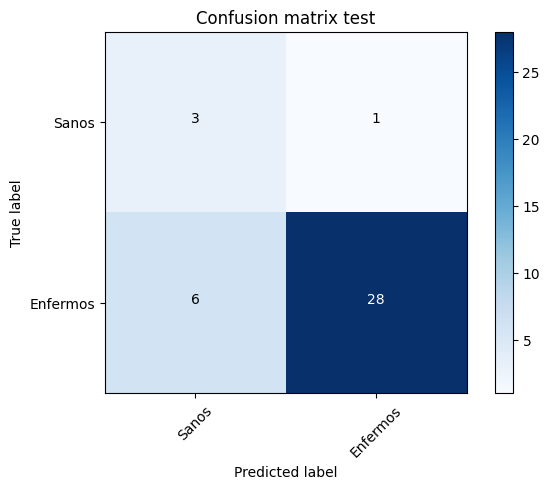

In [ ]:
matriz_1 = confusion_matrix(y1_test,predict_test)
plot_confusion_matrix(matriz_1, classes=target_names,
                      title='Confusion matrix test')

In [ ]:
#X1_train, X1_test, y1_train, y1_test
mlp.score(X1_train,y1_train),mlp.score(X1_test, y1_test)

(0.8181818181818182, 0.8157894736842105)

**ITERACION 2**


In [ ]:
df_con_mean.drop("Enfermedad", axis=1, inplace=True)
target_column = ['Diagnostico'] #Sano - Enfermo
predictors = list(set(list(df_con_mean.columns))-set(target_column))
print(predictors)

df_con_mean[predictors] = df_con_mean[predictors]/df_con_mean[predictors].max()
df_con_mean.describe()

['Genero', 'pid', 'Sibilancias_mean', 'Edad', 'Crepitancias_mean']


,Diagnostico
count,126.000000
mean,0.793651
std,0.406300
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
X1 = df_con_mean[predictors].values
y1 = df_con_mean[target_column].values

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=40) #test 30% - train 70%, flag = 40
y1_test = np.squeeze(y1_test)
y1_train = np.squeeze(y1_train) 
print(X1_train.shape)
print(y1_train.shape)

print(X1_test.shape)
print(y1_test.shape)

(88, 5)
(88,)
(38, 5)
(38,)


In [ ]:
# creación de un objeto de la clase MLPClassifier, que es un clasificador de redes neuronales multicapa (Multi-Layer Perceptron, MLP) en la biblioteca scikit-learn.
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500) 
print(mlp)

MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=500)


In [ ]:
# se entrena el modelo MLPClassifier y realizan predicciones utilizando el conjunto de entrenamiento y el conjunto de prueba.
mlp.fit(X1_train,y1_train) 
predict_train = mlp.predict(X1_train) 
predict_test = mlp.predict(X1_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



In [ ]:
print(confusion_matrix(y1_test,predict_test))

[[ 2  2]
 [ 4 30]]


In [ ]:
target_names = ['Sanos', 'Enfermos']
print(classification_report(y1_test,predict_test,target_names=target_names))

              precision    recall  f1-score   support

       Sanos       0.33      0.50      0.40         4
    Enfermos       0.94      0.88      0.91        34

    accuracy                           0.84        38
   macro avg       0.64      0.69      0.65        38
weighted avg       0.87      0.84      0.86        38



Confusion matrix, without normalization
[[ 2  2]
 [ 4 30]]


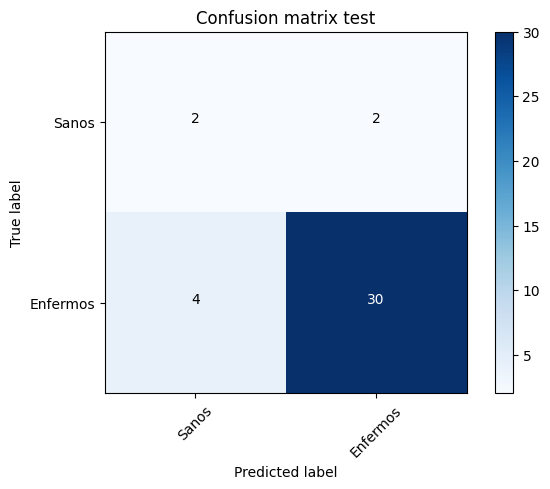

In [ ]:
matriz_1 = confusion_matrix(y1_test,predict_test)
plot_confusion_matrix(matriz_1, classes=target_names,
                      title='Confusion matrix test')

In [ ]:
#X1_train, X1_test, y1_train, y1_test
mlp.score(X1_train,y1_train),mlp.score(X1_test, y1_test)

(0.8636363636363636, 0.8421052631578947)

**ITERACION 3**


In [ ]:
df_it_3.drop("Enfermedad", axis=1, inplace=True)
target_column = ['Diagnostico FR'] #Sano - Enfermo
predictors = list(set(list(df_it_3.columns))-set(target_column))
print(predictors)

df_it_3[predictors] = df_it_3[predictors]/df_it_3[predictors].max()
df_it_3.describe()

['Genero', 'FR', 'Diagnostico', 'pid', 'Crepitancias_mean', 'Edad', 'Sibilancias_mean']


,Diagnostico FR
count,126.000000
mean,0.436508
std,0.497932
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
X1 = df_it_3[predictors].values
y1 = df_it_3[target_column].values

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=40) #test 30% - train 70%, flag = 40
y1_test = np.squeeze(y1_test)
y1_train = np.squeeze(y1_train) 
print(X1_train.shape)
print(y1_train.shape)

print(X1_test.shape)
print(y1_test.shape)

(88, 7)
(88,)
(38, 7)
(38,)


In [ ]:
# creación de un objeto de la clase MLPClassifier, que es un clasificador de redes neuronales multicapa (Multi-Layer Perceptron, MLP) en la biblioteca scikit-learn.
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500) 
print(mlp)

MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=500)


In [ ]:
# se entrena el modelo MLPClassifier y realizan predicciones utilizando el conjunto de entrenamiento y el conjunto de prueba.
mlp.fit(X1_train,y1_train) 
predict_train = mlp.predict(X1_train) 
predict_test = mlp.predict(X1_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



In [ ]:
print(confusion_matrix(y1_test,predict_test))

[[23  2]
 [ 1 12]]


In [ ]:
target_names = ['Sanos', 'Enfermos']
print(classification_report(y1_test,predict_test,target_names=target_names))

              precision    recall  f1-score   support

       Sanos       0.96      0.92      0.94        25
    Enfermos       0.86      0.92      0.89        13

    accuracy                           0.92        38
   macro avg       0.91      0.92      0.91        38
weighted avg       0.92      0.92      0.92        38



Confusion matrix, without normalization
[[23  2]
 [ 1 12]]


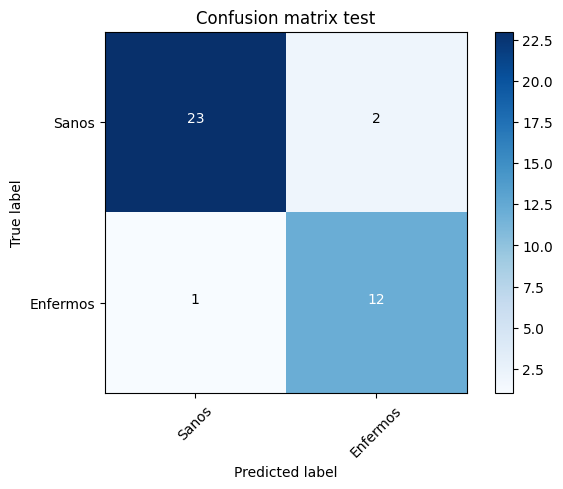

In [ ]:
matriz_1 = confusion_matrix(y1_test,predict_test)
plot_confusion_matrix(matriz_1, classes=target_names,
                      title='Confusion matrix test')